# Characteristic words finder

In this notebook, we build methods for quickly finding and ranking the most "idiosyncratic" words for each person. We do this following the simple math logic of this page: 

http://varianceexplained.org/r/trump-tweets/

The most important equation for how each word is scored for each theorist:

$\Large log\frac{(\frac{word\,ct\,for\, author}{total\, words\, for\, author})}{(\frac{word\, ct\, for\, OTHER \,authors}{total \,words\, for\, OTHER \,authors})}$


Two steps:

1) Extract word counts into a dictionary by [word][author]

2) Convert dictionary into a word score dictionary by [word][author] by the above formula

3) Visualize the results


In [4]:
TEXTS_DIRECTORY = "theory-texts" #this can be changed.

### 1) Extracting word counts

We end up with a frequency dictionary that goes like [word][author] = number

In [6]:
import os
from collections import defaultdict, Counter
from nltk import ngrams

import string

def ngram_tokenize(s, rng=(1,1)):
    """Turn text into a lowercase list of ngrams with no punctuation"""
    simpletext = s.translate(str.maketrans('', '', string.punctuation)).lower().split()
    
    ngram_list = []
    
    for N in range(rng[0], rng[1]+1): #iterate thru Ngram n values
        grams = ngrams(simpletext, N) #create ngrams (each ngram is a list of words)
        for gram in grams: #convert each ngram into string and add to ngram list
            ngram_list.append(' '.join(gram))
    
    return ngram_list
    

def listdir_nothidden(directory):
    """List files/folders in a directory EXCLUDING hidden files, whose names start with a dot"""
    files = os.listdir(directory)
    return [filename for filename in files if not filename.startswith(".")]


def clean_words(dictionary, word_list):
    """Set a list of words' counts to 0"""
    for word in word_list:
        try:
            for author in dictionary[word].keys():
                dictionary[word][author]=0
        except:
            print(word, "not found in dictionary")
            
    return dictionary

def word_counts(directory):
    """Extract word count based on assumption that subdirectory name is author name"""
    #make a list of the folders (ignoring hidden files!)
    authorfolders = listdir_nothidden(directory)

    word_count_dict = defaultdict(Counter)

    for authorname in authorfolders:
        for textfile in listdir_nothidden(directory+"/"+authorname):
            print(listdir_nothidden(directory+"/"+authorname))
            f = open(directory+"/"+authorname+"/"+textfile, errors = "ignore", encoding = "utf-8") #open the text file
            textstring = f.read()

            #loop through text file
            for word in ngram_tokenize(textstring, rng=(1,1)): #create ngrams with given range of n
                word_count_dict[word][authorname] += 1 #increment the word's entry for that author name

            f.close() #close the file now that we're done with it       
    
    return word_count_dict


#create the dictionary
word_count_dict = word_counts(TEXTS_DIRECTORY)


#clean the dictionary of SPECIFIC WORDS we know we don't want to be in there
words_to_remove = ['ect', 'bj', 'eology', 'subj', 'obj', 'subli']
word_count_dict = clean_words(word_count_dict, words_to_remove)



['butler-gender_trouble.txt']
['discipline-punish.txt']
['sublime-object.txt']
['derrida_dissemination.txt']


Pickle the dictionary

In [3]:
import pickle

# Store data (serialize)
with open('word-counts.pickle', 'wb') as handle:
    pickle.dump(word_count_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


### 2) Create dictionary of word specificity scores for each author

Now, we use the logarithm formula spacified above to create a new [author][word] dictionary that tells you the word's specificity score (as logarithm ratio) of each word for each author

In [30]:
from math import log

def word_score_formula(author_word_nr, author_total_words, corpus_word_nr, corpus_total_words):
    """Score words -- but only those over a certain number of occurences
    IMPORTANT NOTE: compares this author's usage to ALL OTHER authors, excluding the one under consideration"""
    
    if corpus_word_nr >= 15.0: #only score those words which have over this many occurences
        result = log(((author_word_nr+1)/(author_total_words+1))/
                     ((corpus_word_nr-author_word_nr+1)/(corpus_total_words-author_total_words+1))) #subtract this author's counts from the total
    else:
        result = -9999.0
    
    return result

def word_score(word_count_dict):
    """Given a word count dictionary, return a dictionary of word idiosyncracy scores like [author][word]"""

    total_words_per_author = Counter()
    for word in word_count_dict.keys(): #iterate through words in our count dict
        for author in word_count_dict[word].keys(): #iterate through authors
            total_words_per_author[author] += word_count_dict[word][author] #add that authors count for that word to that author's total word count

    corpus_word_count = sum(total_words_per_author.values()) #find out how many words in total

    word_scores = defaultdict(defaultdict) #initialize blank two level dictionary of sort [author][word]

    for word in word_count_dict.keys(): #iterate through words in our count dict
        corpus_word_nr = sum(word_count_dict[word].values()) #how many times this word is used in GENERAL
        #print(corpus_word_nr)
        #print(word, corpus_word_nr)
        for author in word_count_dict[word].keys(): #iterate through authors
            author_word_nr = word_count_dict[word][author] #how many times THIS AUTHOR uses the word
            word_scores[author][word] = word_score_formula(author_word_nr, total_words_per_author[author], corpus_word_nr, corpus_word_count)
            #print(word_scores[author][word])
            
    #clean up the results--remove words that didn't meet the minimum occurence threshold:

    #find words to drop
    dropkeys = []
    for author in word_scores.keys():
        for key, value in word_scores[author].items():
            if value == -9999.0:
                dropkeys.append(key)


    #copy score dictionary for author, remove the terms and replace the original dictionary with the new one
    for author in word_scores.keys():
        newdict = word_scores[author]
        for key in dropkeys:
            try:
                newdict.pop(key)
            except:
                continue
        word_scores[author] = newdict #replace word score entry for that author with the newly-created cleaned-up dictionary
        
    return word_scores

def author_word_scores_text(word_scores):
    scoretext = ""
    for author in word_scores.keys():
        ranked_words = sorted(word_scores[author].items(), key=lambda x: x[1], reverse=True)
        wordlist = [item[0] for item in ranked_words] #remove the scores
        scoretext += "Most characteristic words for {}:\n{}\n\n".format(author, wordlist[:5])
    return scoretext


#print the top scores
print(author_word_scores_text(word_score(word_count_dict)))

Most characteristic words for Judith Butler:
['gender', 'heterosexual', 'heterosexuality', 'wittig', 'lesbian']

Most characteristic words for Michel Foucault:
['delinquency', 'illegality', 'penitentiary', 'imprisonment', 'illegalities']

Most characteristic words for Slavoj Zizek:
['jew', 'traumatic', 'misrecognition', 'vuoi', 'antagonism']

Most characteristic words for Jacques Derrida:
['hymen', 'pharmakon', 'session', 'mallarme', 'socrates']




We do have to do some work to clean the results, specifically to completley remove the words which were below the frequency threshold, used too rarely to matter. They will not have a score saved.

['Judith Butler', 'Michel Foucault', 'Slavoj Zizek', 'Jacques Derrida']

### 3) Ranking words in dataframes

Each author gets their own dataframe

In [6]:
import pandas as pd

def scores_to_dataframes(word_score_dicts):
    """Takes a dictionary of dictionaries of words scores (author is key) and returns a dictionary of dataframes, where the author is the key.
    The scores are 'specialness' scores, as it were, rather than counts. """
    dfs = defaultdict() #dictionary of dataframes by name
    for author, scoredict in word_score_dicts.items(): #loop through authors (key), and dictionaries of word score (value)
        #create a new dataframe for that author's word scores. add df to the dictionary of dataframes, label the with the author's name, and sort scores in ascending order
        dfs[author]=pd.DataFrame.from_dict(scoredict, orient='index').sort_values(by=0, ascending=False).rename(columns = {0: author})
    return dfs

dfs = scores_to_dataframes(word_scores)

#print the values to show top
for df in dfs.values():
    print("\n", df.head(3))



                  Judith Butler
gender                8.210356
heterosexual          6.675026
heterosexuality       6.403092

               Michel Foucault
delinquency          5.534236
illegality           5.411633
penitentiary         5.255064

                 Slavoj Zizek
jew                 5.332154
traumatic           5.238628
misrecognition      4.862151

            Jacques Derrida
hymen             5.657502
pharmakon         5.573115
session           5.340492


### 4) Graphing results

We use subplots to graph the top several words in each dataframe.

4


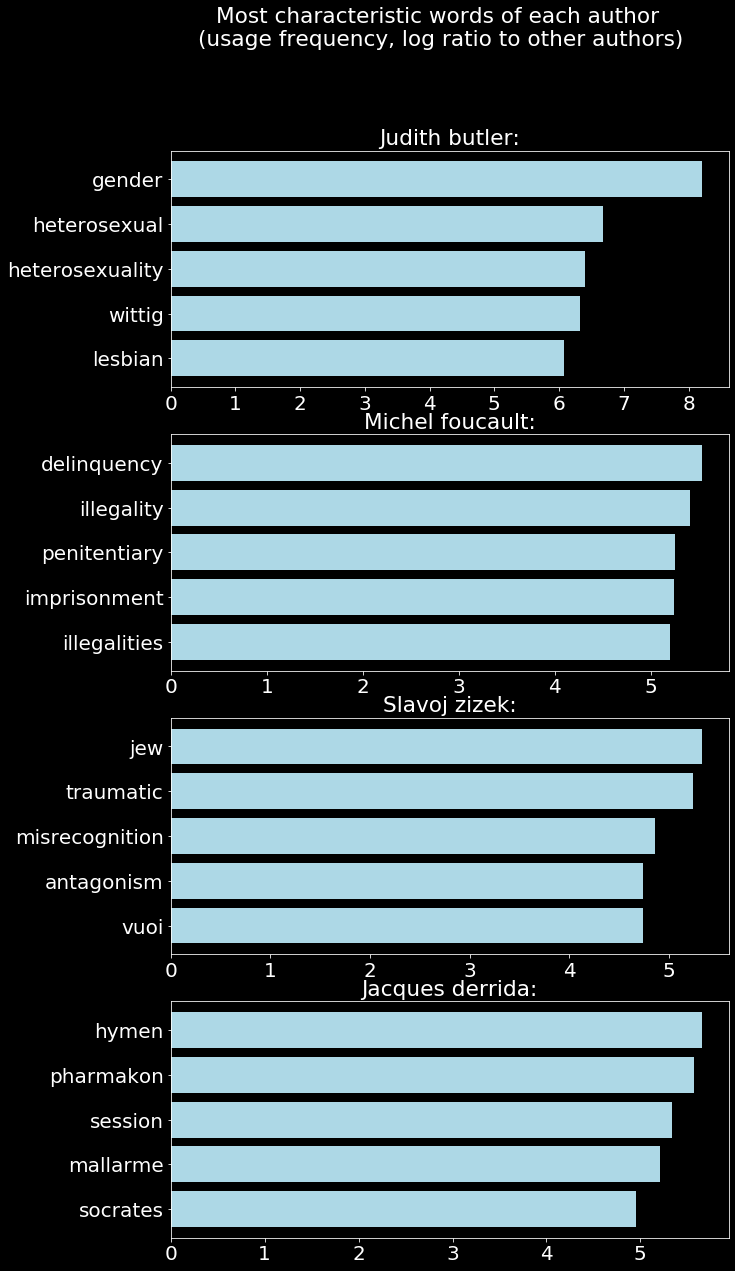

In [7]:
import matplotlib.pyplot as plt

def plot_dfs(dfs):
    """Given a dictionary of dataframes with word characteristic scores for each author, graph them as bar charts as subplots"""
    plt.style.use('dark_background')

    plt.rc('xtick', labelsize=20) 
    plt.rc('ytick', labelsize=20) 
    plt.rcParams.update({'font.size': 18})

    n_authors = len(dfs)
    print(n_authors)

    fig, axs = plt.subplots(n_authors, figsize=(10,5*n_authors)) #create as many subplots as authors
    fig.suptitle('Most characteristic words of each author \n(usage frequency, log ratio to other authors)')
    
    authorindex = 0 #this index will make sure each author is assigned a corresponding subplot
    
    for author, df in dfs.items():
        axs[authorindex].barh(df.head().index[::-1], df.head()[author][::-1], color = "lightblue") #reversing order with the ::-1 thing!
        axs[authorindex].title.set_text(author.capitalize()+":")
        authorindex += 1 #increment author index
        
    plt.show()
    

plot_dfs(dfs)


## 5) Writing a new text's most specific words + the assigned author's most specific words:

## The new text's most specific words

In [14]:
def word_score_formula_new_text(author_word_nr, author_total_words, corpus_word_nr, corpus_total_words):
    """Score words for specificity to this new text -- but only those over a certain number of occurences
    IMPORTANT NOTE: compares this new text's usage to ALL  authors in the training corpus, excluding nobody from original word count dictionary
    this puts it in contrast with the previous version of this method"""
    
    if author_word_nr >= 2.0: #only score those words which have over this many occurences FOR THIS AUTHOR (previous version looked at total corpus occurences)
        result = log(((author_word_nr+1)/(author_total_words+1))/
                     ((corpus_word_nr+1)/(corpus_total_words+1))) #subtract this author's counts from the total
    else:
        result = -9999.0
    
    return result


def new_text_word_score(new_text, corpus_word_count_dict):
    """Given a NEW TEXT, return a dictionary of word idiosyncracy scores for this new text, compared to our training corpus."""

    #generate ngram count dictionary
    newtext_ngrams = ngram_tokenize(newtext)
    new_text_counts = Counter(newtext_ngrams)
    
    #get how many words each author used in corpus, as dictionary of author counts
    total_words_per_author = Counter()
    for word in word_count_dict.keys(): #iterate through words in our count dict
        for author in word_count_dict[word].keys(): #iterate through authors
            total_words_per_author[author] += word_count_dict[word][author] #add that authors count for that word to that author's total word count

    #find out how many words in total in training corpus    
    corpus_word_count = sum(total_words_per_author.values()) 
    
    
    #initialize dictionary. [word] returns idiosyncrasy score for this text's words
    word_scores = defaultdict() 
    
    #total number of new words for the new text
    new_text_totalwords = sum(new_text_counts.values()) 

    for word in new_text_counts.keys(): #iterate through words in our count dictionary for the new text
        corpus_word_nr = sum(corpus_word_count_dict[word].values()) #how many times this word is used in GENERAL IN THE CORPUS

        newtext_word_nr = new_text_counts[word] #how many times the new text uses the word
        
        #we score the idiosyncrasy of this word to this new text
        word_scores[word] = word_score_formula_new_text(newtext_word_nr, new_text_totalwords, corpus_word_nr, corpus_word_count)
        #print(word_scores[author][word])
    return word_scores

def new_text_top_words(new_text, corpus_word_counts):
    """Generate sorted list of most specific words to new text, vs. corpus word counts"""
    newtext_scores = new_text_word_score(new_text, corpus_word_counts)
    return sorted(newtext_scores.items(), key=lambda x: x[1], reverse=True)
    

    
    
    
    
    
    
    
#import word count dicitonary for corpus
with open('word-counts.pickle', 'rb') as handle:
    word_counts_imported = pickle.load(handle) #import this [word][author] count dictionary
    
#import test text
testpath = "/Users/macbook/Downloads/fountainpen.txt"
f = open(testpath, "r")
newtext = f.read()

#get new text's specific words, ranked!
top10 = new_text_top_words(newtext, word_counts_imported)[:10]

top10

#we have successfully produced a sorted list of words and specificity scores TO THE NEW TEXT.

[('fountain', 8.09889656913234),
 ('bottle', 7.559900068399653),
 ('dg', 7.405749388572395),
 ('cornell’s', 7.405749388572395),
 ('2014', 7.405749388572395),
 ('defunct', 7.405749388572395),
 ('fountain”', 7.405749388572395),
 ('2nd', 7.405749388572395),
 ('hydration', 7.405749388572395),
 ('fountain’s', 7.405749388572395)]

## The assigned author's most specific words:

In [9]:
def characteristic_words_ranked(author, scores_dict):
    scores = scores_dict[author]
    return sorted(scores.items(), key=lambda x: x[1], reverse=True)

characteristic_words_ranked("Judith Butler", word_scores)[:10]

[('gender', 8.210355920121678),
 ('heterosexual', 6.6750259798413),
 ('heterosexuality', 6.403092264357658),
 ('wittig', 6.33018549354957),
 ('lesbian', 6.072850577487081),
 ('culturally', 5.678196385483132),
 ('gendered', 5.645406562660142),
 ('herculine', 5.594113268272591),
 ('cultural', 5.511875170035619),
 ('argues', 5.502305719019469)]

## SUSPENDED) Identifying words that the NEW TEXT shares in common with the theorist it got assigned to

### Actually we will not be pursuing this route either, even though it works -- it's too messy for the conclusions to be meaningful

In [10]:
#import test text
testpath = "/Users/macbook/Downloads/fountainpen.txt"
f = open(testpath, "r")
newtext = f.read()

In [11]:
#top words in new text

def list_unique_ngrams(newtext):
    """Return a set of unique ngrams in the text."""
    #generate ngram count dictionary
    newtext_ngrams = ngram_tokenize(newtext)
    return set(newtext_ngrams)
    
list_unique_ngrams(newtext)


#find characteristic words of assigned author
assigned_author = "Michel Foucault"
author_word_scores = word_scores[assigned_author]
characteristic_words = [] #put characteristic words in here

#OUR CRITERION: THE AUTHOR'S WORD SCORE SHOULD BE ABOVE 2 FOR THAT WORD TO BE CHARACTERISTIC

for word, score in author_word_scores.items():
    if score >= 1.5:
        characteristic_words.append(word)
        
characteristic_words

    

['great',
 'was',
 'rights',
 'information',
 'power',
 'had',
 'examination',
 'took',
 'brought',
 'z',
 'france',
 'legal',
 'distribution',
 'ritual',
 'day',
 'school',
 'bring',
 'popular',
 'public',
 'control',
 'learning',
 'forced',
 'age',
 'prevent',
 'condemned',
 'judge',
 'regarded',
 'increasing',
 'carry',
 'gave',
 'rise',
 'subtle',
 'institutions',
 'medical',
 'disciplinary',
 'authorities',
 'individual',
 'year',
 'throughout',
 'individuals',
 'right',
 'period',
 'constraint',
 'applied',
 'distributed',
 'building',
 'sovereign',
 'disorder',
 'application',
 'organized',
 'committed',
 'responsibility',
 'investigation',
 'police',
 'isolation',
 'subjection',
 'useful',
 'groups',
 'goods',
 'behaviour',
 'observation',
 'religious',
 'tortured',
 'morality',
 'modality',
 'punished',
 'punishing',
 'proof',
 'patient',
 'patients',
 'punishments',
 'code',
 'punitive',
 'privileged',
 'imposing',
 'humanity',
 'prison',
 'reform',
 'criminal',
 'regulations

In [12]:
log(1)

0.0

## ABANDONED: Comparing a *new text*'s word usage against the the whole corpus (hard version)

**A) Sorting words based on their specificity to the new text (compared to the whole training corpus)**

I.e. this shows us what sets the new author apart from the whole training set people.

**B) Sort the top words to see whether they intersect with the most-specific words to the assigned author's corpus.**

Two steps:
1. Identify the most-used words in the new text (let's say the top 20%) (this is cruder than the likely-better method of counting against the whole corpus MINUS the assigned author.
2. Identify an overlap with that author's most-specific words.

---
We begin with step 1), in several sub steps:

Step 1.1. Remove the assigned author from the corpus word count dictionary (simply create new dictionary).



In [13]:
#remove assigned author from word count corpus

def remove_author_from_word_counts(authorname, word_counts):
    """Taking a [word][authorname] double layer dictionary, return a copy with one of the authors removed"""
    
    #the dictionary is [word][author], so we have to remove the author from each word's entry
    for word in updated_word_counts.keys():
        del word_counts[word][authorname] #remove the given authorname's entry from that word
        
    return word_counts

updated_word_counts = remove_author_from_word_counts("Michel Foucault", word_counts_imported) 


NameError: name 'updated_word_counts' is not defined

Step 1.2. Score the new text's word specificity against this new word count dictionary (based on methods defined in part A)


In [ ]:
newtext_scores_minus_author = new_text_word_score(new_text_wordcounts, updated_word_counts)
sorted_scores_minus_author = sorted(newtext_scores_minus_author.items(), key=lambda x: x[1], reverse=True)

Step 2: Identifying an overlap with that author's most specific words

HONESTLY, THIS IS A FRUITLESS EXERCISE. ABANDONING FOR SOMETHING MUCH SIMPLER

In [ ]:
author_wordscores_sorted = 